In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MaxAbsScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score

from sklearn.model_selection import GridSearchCV

from sklearn.base import BaseEstimator

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import time
import os

import sys

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Logistic Regression Implementation


In [ ]:
class LogisticRegressionGD(BaseEstimator):

  def __init__(self, no_of_iterations=1000, lambda_reg =  0.1, learning_rate=0.05, regularization=False):

    self.no_of_iterations = no_of_iterations
    self.lambda_reg = lambda_reg
    self.learning_rate = learning_rate

    self.biases_ = None
    self.weights_ = None

    self.encoder = OneHotEncoder()
    self.no_of_unique_labels = None

    self.costs = []
    self.tol = 1e-4
    self.regularization = regularization

  def fit(self, X_train, y_train):

    # convert both the input to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train).reshape(-1, 1)

    y_train_enc = self.encoder.fit_transform(y_train).toarray() # One hot encoder applied. y_train now has a vector at each row for each label

    self.no_of_unique_labels = len(np.unique(y_train))

    # initialize  and add the bias column
    bias_column = np.ones( (X_train.shape[0], 1) )
    X_train = np.hstack(( bias_column, X_train)) # addint bias column to X_train

    # initialize the weight AND get the unique labels
    no_of_labels_minus_1 = len(np.unique( y_train ))-1
    weights = np.random.rand( X_train.shape[1], no_of_labels_minus_1)

    conditional_probabilities = np.exp( np.dot(   X_train, weights ) ) # shape ()

    #print('conditional probablities shape, before adding last rows: ', conditional_probabilities.shape)
    sum_across_rows = np.array( np.sum(conditional_probabilities , axis = 1 ) + 1).reshape(1, -1) # shape (900)
    #print('sum_across_rows shape: ',sum_across_rows.shape) # (1, 71) this is the right shape

    conditional_probabilities = conditional_probabilities / sum_across_rows.reshape(-1, 1)
    last_column = np.array( 1/sum_across_rows).reshape( - 1, 1)
    conditional_probabilities = np.hstack( (conditional_probabilities, last_column) )

    #print('conditional probablities shape, after adding last rows: ', conditional_probabilities.shape)

    """
    1. Conditional Log Likelihood
    """

    y_pred = np.argmax(conditional_probabilities, axis=1).reshape(-1, 1) # label predicted
    y_prob = np.max(conditional_probabilities, axis=1).reshape(-1, 1) # probability of predicted label


    #print('----- WEIGHT UPDATE -----')

    for epoch in range(1000):
      weights = self.gradient_descent( X_train, y_train_enc, weights)

    #print('-------------------------')

    """
    Store weights after training
    """
    self.weights_ = weights

    """
    Training is complete. weights now has the updated weights
    """

  def conditional_probabilities(self, X, weights):
    """
    This method does not add bias column to the X feature set
    """

    # get the unique labels
    no_of_labels_minus_1 = len(np.unique( y_train ))-1
    conditional_probabilities = np.exp( np.dot(   X, weights ) )

    #print('conditional probablities shape, before adding last column: ', conditional_probabilities.shape)
    sum_across_rows = np.array( np.sum(conditional_probabilities , axis = 1 ) + 1).reshape(1, -1) # shape (900)
    #print('sum_across_rows shape: ',sum_across_rows.shape) # (1, 71) this is the right shape

    conditional_probabilities = conditional_probabilities / sum_across_rows.reshape(-1, 1)
    last_column = np.array( 1/sum_across_rows).reshape( - 1, 1)

    conditional_probabilities = np.hstack( (conditional_probabilities, last_column) )

    #if not np.allclose( 1, np.sum(conditional_probabilities, axis=1) ):
    #  print('sum across rows is NOT 1')

    return conditional_probabilities

  def predict(self, X_test):
    # get the unique labels
    no_of_labels_minus_1 = self.no_of_unique_labels - 1
    weights = self.weights_

    # initialize  and add the bias column
    bias_column = np.ones( (X_test.shape[0], 1) )
    X_test = np.hstack(( bias_column, X_test)) # addint bias column to X_train

    conditional_probabilites = self.conditional_probabilities(X_test, self.weights_)

    y_pred_index = np.argmax( conditional_probabilites, axis=1).reshape(-1, 1) # label predicted
    y_prob = np.max( conditional_probabilites, axis=1).reshape(-1, 1) # probability of predicted label

    y_pred = np.zeros(( X_test.shape[0], self.no_of_unique_labels ))

    """
    At each row of y_pred, at I want to set 1 for the index value in y_pred index
    """

    y_pred[ np.arange(len(y_pred)), y_pred_index.ravel() ] = 1

    return self.encoder.inverse_transform(y_pred)

  def get_costs(self):
    return self.costs

  def cross_entropy(self, output, y_target):
    return - np.sum(np.log(output + 1e-9) * (y_target), axis=1)

  def compute_cost(self, output, y_target):
    return np.mean(self.cross_entropy(output, y_target))

  def gradient_descent(self, X, y_enc, weights):

    for i in range(self.no_of_iterations):

      conditional_probabilities = self.conditional_probabilities(X, weights) # aka softmax

      diff = conditional_probabilities - y_enc
      mse = np.mean(diff, axis = 0 ) # not sure how to use this though

      # gradient -> n_features x n_classes (n x m)

      # X tranpose -> n_features x n_instances (k )
      # diff -> n_instances
      #print('X shape : ', X.shape)
      #print('conditional probabilites shape : ', conditional_probabilities.shape)
      #print('diff shape : ', diff.shape)

      gradient = np.dot(X.T, diff) # this is the line I was missing
      #print('gradient shape : ', gradient.shape)

      # weight update in opposite direction
      weights -= ( self.learning_rate * gradient[:, 0:-1] )

      # regularization term
      if self.regularization:
         weights += self.learning_rate * self.lambda_reg * weights

      """
      Two expressions above sums up eqn 29
      """

      #cost = self.cost(self.compute_cost( conditional_probabilities, y_enc ) )
      cost = self.compute_cost( conditional_probabilities, y_enc )

      self.costs.append(cost) # ok

      return weights
      """
      Get the cost and and add it to list
      """

In [ ]:
TEST_FILE_PATH = "test.csv" #"/content/drive/MyDrive/CS529/test.csv"
TRAIN_FILE_PATH = "train.csv" #"/content/drive/MyDrive/CS529/train.csv"

df_train = pd.read_csv(TRAIN_FILE_PATH)

df_train = df_train.sample(frac=1)
df_test = pd.read_csv(TEST_FILE_PATH)

# Get X_train and y_train

X_train = df_train.iloc[:, 0:-1]
y_train = df_train.iloc[:, -1]


X_test = df_test

# Standardize the data to overcome overflow
std = StandardScaler()
pca = PCA(n_components=0.95)


X_train_std = std.fit_transform( X_train )
X_test_std = std.transform(X_test)

X_train_std_pca = pca.fit_transform(X_train_std)
X_test_std_pca = pca.transform(X_test_std)


# Do maximum absolutte scaling on
# Use MaxAbsScaler
mab_scaler_0 = MaxAbsScaler()

X_train_std_pca_mab = mab_scaler_0.fit_transform(X_train_std_pca )
X_test_std_pca_mab = mab_scaler_0.transform(X_test_std_pca)


print('X_train_std_pca shape : ', X_train_std_pca.shape)
print('X_test_std_pca shape : ', X_test_std_pca.shape)

print('y_train shape : ', y_train.shape)
print( np.unique(y_train, return_counts=True) )
print(df_train.head())

X_train_std_pca shape :  (900, 70)
X_test_std_pca shape :  (100, 70)
y_train shape :  (900,)
(array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object), array([90, 90, 90, 90, 90, 90, 90, 90, 90, 90]))
              0           1          2          3          4          5  \
121  -45.855606  107.999084 -11.737645  66.326881 -30.206829   9.242658   
749 -173.443466  105.070961   1.155593  24.115499  22.134285   2.548073   
0    -94.507706   55.671040  29.266260  27.035044  20.046722   1.184787   
495 -402.208252  153.976746 -15.228629  15.294281  -3.071624  -3.183727   
557  -52.480682   99.707962 -47.386406  47.017590 -21.017344  22.883759   

             6          7          8          9  ...       1379       1380  \
121 -25.778023  21.871576 -17.935884  10.272776  ...  19.656661  21.859923   
749  -1.589373   0.166444  -5.327747   3.813227  ...  24.519968  21.655132   
0    12.946829  -0.798539   8.866569  -0.681519 

In [ ]:
( np.array([2, 4, 6, 12, 10]) == np.array([2, 4, 6, 8, 10]) ).astype(int)

array([1, 1, 1, 0, 1])

In [ ]:
#np.unique( y_pred, return_counts=True)

In [ ]:

"""
TRAIN-VALIDATION TEST
"""

df_train = pd.read_csv(TRAIN_FILE_PATH)
df_test = pd.read_csv(TEST_FILE_PATH)

# Get X_train and y_train

X_train_ = df_train.iloc[:, 0:-1]
y_train_ = df_train.iloc[:, -1]


# split the data into train and validation
X_tr , X_val , y_tr, y_val = train_test_split(X_train_, y_train_, test_size=0.15, )


# Standardize the data to overcome overflow
std1 = StandardScaler()
pca1 = PCA(n_components=0.95)

X_tr_std = std1.fit_transform( X_tr )
X_val_std = std1.transform(X_val)

X_tr_std_pca = pca1.fit_transform(X_tr_std)
X_val_std_pca = pca1.transform(X_val_std)

print(X_tr_std_pca.shape)


# Use MaxAbsScaler
mab_scaler = MaxAbsScaler()

X_tr_std_pca_mab = mab_scaler.fit_transform(X_tr_std_pca )
X_val_std_pca_mab = mab_scaler.transform(X_val_std_pca)

(765, 68)


In [ ]:
start_time_1 = time.time()

clf1 = LogisticRegressionGD(no_of_iterations=10, lambda_reg =  0.1, learning_rate=0.01)
#clf1.fit(np.clip( X_tr_std_pca, -1.0**-3, 1.0**3 ), y_tr)
clf1.fit(X_tr_std_pca_mab , y_tr)

#clf1.fit( X_tr_std_pca, y_tr)

end_time_1 = time.time()

#print(accuracy_score(y_val, y_pred1)*100)



In [ ]:
y_pred1 = clf1.predict(X_val_std_pca_mab)


print('accuracy score : ', accuracy_score(y_val, y_pred1) )


accuracy score :  0.7185185185185186


In [ ]:
# Assuming you have your data prepared (X_train, X_test, y_train, y_test)

# Define hyperparameter grid

param_grid = {
    'no_of_iterations': [100, 500, 1000],  # Number of training iterations
    'learning_rate': [0.001, 0.01, 0.1],

    'lambda_reg': [0.01, 0.1, 1.0],  # Regularization parameter (lambda)
    'regularization':[True, False]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=LogisticRegressionGD(), param_grid=param_grid, cv=5, scoring='accuracy')


In [ ]:
grid_time_start = time.time()
grid_search.fit(X_train_std_pca_mab, y_train)
grid_time_end = time.time()

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_




<ipython-input-19-84d2955e04e1>:80: RuntimeWarning: overflow encountered in exp
  conditional_probabilities = np.exp( np.dot(   X, weights ) )
<ipython-input-19-84d2955e04e1>:80: RuntimeWarning: overflow encountered in exp
  conditional_probabilities = np.exp( np.dot(   X, weights ) )
<ipython-input-19-84d2955e04e1>:80: RuntimeWarning: overflow encountered in exp
  conditional_probabilities = np.exp( np.dot(   X, weights ) )
<ipython-input-19-84d2955e04e1>:80: RuntimeWarning: overflow encountered in exp
  conditional_probabilities = np.exp( np.dot(   X, weights ) )
<ipython-input-19-84d2955e04e1>:80: RuntimeWarning: overflow encountered in exp
  conditional_probabilities = np.exp( np.dot(   X, weights ) )
<ipython-input-19-84d2955e04e1>:80: RuntimeWarning: overflow encountered in exp
  conditional_probabilities = np.exp( np.dot(   X, weights ) )
<ipython-input-19-84d2955e04e1>:80: RuntimeWarning: overflow encountered in exp
  conditional_probabilities = np.exp( np.dot(   X, weights ) )

In [ ]:
print('best params : ', best_params)

best params :  {'lambda_reg': 1.0, 'learning_rate': 0.01, 'no_of_iterations': 100, 'regularization': False}


In [ ]:
print('best model : ', best_model)

best model :  LogisticRegressionGD(lambda_reg=1.0, learning_rate=0.01, no_of_iterations=100)


In [ ]:
print('Time taken for logistic regression grid search : ', -grid_time_start+grid_time_end , ' seconds')

Time taken for logistic regression grid search :  543.29740858078  seconds


## Result (in accuracy) of our implementation

In [ ]:
best_model.fit(X_tr_std_pca_mab, y_tr)
y_pr = best_model.predict(X_val_std_pca_mab)

print( accuracy_score( y_val, y_pr)*100 )
print( precision_score( y_val, y_pr, average='macro') *100)
print( recall_score( y_val, y_pr, average='macro') *100)
print( f1_score( y_val, y_pr, average='macro')*100 )

71.85185185185186
71.2569130216189
71.02077579283461
70.52663762572845


### Cost Function Plot of Our Implementation

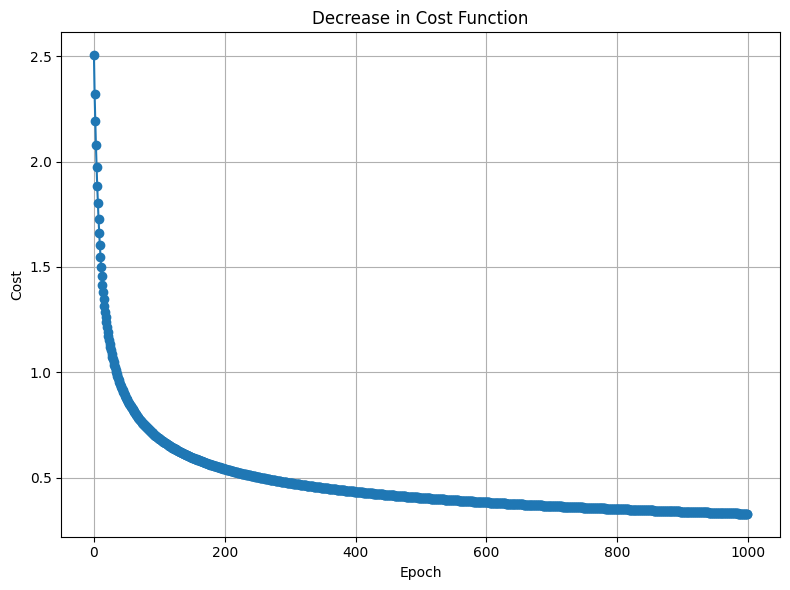

In [ ]:
costs_ = best_model.get_costs()[:1000]



x_values = range(len(costs_))

# Plot the list of numbers
plt.figure(figsize=(8, 6))  # Set the figure size
plt.plot(x_values, costs_, marker='o', linestyle='-')  # Plot with markers
plt.title('Decrease in Cost Function')  # Set the title
plt.xlabel('Epoch')  # Set the label for the x-axis
plt.ylabel('Cost')  # Set the label for the y-axis
plt.grid(True)  # Display grid
plt.tight_layout()  # Adjust the layout to make sure everything fits without overlapping

# Show the plot
plt.show()

In [ ]:
new_model_0 = LogisticRegressionGD(lambda_reg= 0.1, learning_rate= 0.01, no_of_iterations= 1000, regularization= False)

new_model_0.fit(X_train_std_pca_mab, y_train) # Train on the complete train set with all 900 instances


In [ ]:
#y_pr_ = new_model_0.predict(X_test_std_pca_mab)

#print( accuracy_score( y_test, y_predict)*100 )
##print( precision_score( y_test, y_predict, average='macro') *100)
#print( recall_score( y_test, y_predict, average='macro') *100)
#print( f1_score( y_test, y_predict, average='macro')*100 )

#X_train_std_pca_mab.shape, X_test_std_pca_mab.shape
#y_predict = best_model.predict(X_test_std_pca_mab)

In [ ]:
TEST_FILENAME_PATH = 'test_filename.npy'
file_array = np.load(TEST_FILENAME_PATH)
# Convert list to numpy array
#file_array = np.array(file_list)

In [ ]:
df_submission = pd.DataFrame({
    'id': file_array.flatten(),
    'class': y_predict.flatten()
})


df_submission.set_index('id', inplace=True, drop=True)

In [ ]:
df_submission.to_csv('/Result/result_1.csv')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

forest = RandomForestClassifier()
gnb = GaussianNB()
svc = SVC()

# Hyperparameters for random forest
param_grid_tree = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Hyperparameters for svc
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4, 5],
    'probability': [True]
}


forest_grid_search = GridSearchCV(forest, param_grid_tree, cv=5, verbose=2, n_jobs=-1)

forest_start_time = time.time()
forest_grid_search.fit( X_train_std_pca_mab, y_train)  # Assuming you have X_train and y_train
forest_end_time = time.time()

print(f"Random Forest Grid Search took {forest_end_time - forest_start_time} seconds.")
print(f"Best parameters for Random Forest: {forest_grid_search.best_params_}")

# Get the best model
best_forest_model = forest_grid_search.best_estimator_

# GridSearchCV for SVC
svc_grid_search = GridSearchCV(svc, param_grid_svc, cv=5, verbose=2, n_jobs=-1)

svc_start_time = time.time()
svc_grid_search.fit(X_train, y_train)  # Assuming you have X_train and y_train
svc_end_time = time.time()

print(f"SVC Grid Search took {svc_end_time - svc_start_time} seconds.")
print(f"Best parameters for SVC: {svc_grid_search.best_params_}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Random Forest Grid Search took 658.4250378608704 seconds.
Best parameters for Random Forest: {'bootstrap': False, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 5 folds for each of 128 candidates, totalling 640 fits
SVC Grid Search took 1223.3288955688477 seconds.
Best parameters for SVC: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}


## Random Forest in Sci-Kit Learn

In [ ]:
# further analysis of random forest

forest_best_estimator = forest_grid_search.best_estimator_

forest_best_estimator.fit(X_train_std_pca_mab, y_train)

forest_prediction = forest_best_estimator.predict(X_test_std_pca_mab)

df_submission_forest = pd.DataFrame({
    'id': file_array.flatten(),
    'class': y_predict.flatten()
})


df_submission_forest.set_index('id', inplace=True, drop=True)
#df_submission_forest.to_csv('/content/drive/MyDrive/CS529/result_forest.csv')


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


## Random Forest in sklearn for different metrics

In [ ]:
forest_best_estimator.fit(X_tr_std_pca_mab, y_tr)
forest_prediction = forest_best_estimator.predict(X_val_std_pca_mab)

print( accuracy_score(y_val,forest_prediction) *100)
print( precision_score(y_val,forest_prediction, average='macro') *100)
print( recall_score(y_val,forest_prediction, average='macro') *100 )
print( f1_score(y_val,forest_prediction, average='macro') *100 )


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


79.25925925925927
78.01824319471378
77.6935152910385
76.8432229876727


## Support Vector Machine in Sci-Kit Learn


In [ ]:
# further analysis of support vector classifier

svc_best_estimator = svc_grid_search.best_estimator_

svc_best_estimator.fit(X_train_std_pca_mab, y_train)

svc_prediction = svc_best_estimator.predict(X_test_std_pca_mab)

df_submission_svc = pd.DataFrame({
    'id': file_array.flatten(),
    'class': y_predict.flatten()
})


df_submission_svc.set_index('id', inplace=True, drop=True)
#df_submission_svc.to_csv('/content/drive/MyDrive/CS529/result_svc.csv')


## Result of Different Metrics in sklearn SVM

In [ ]:
svc_best_estimator.fit(X_tr_std_pca_mab, y_tr)
svc_prediction = svc_best_estimator.predict(X_val_std_pca_mab)

print( accuracy_score(y_val,svc_prediction) *100)
print( precision_score(y_val,svc_prediction, average='macro') *100)
print( recall_score(y_val,svc_prediction, average='macro') *100 )
print( f1_score(y_val,svc_prediction, average='macro') *100 )
"""
df_submission_svc = pd.DataFrame({
    'id': file_array.flatten(),
    'class': y_predict.flatten()
})
"""

#df_submission_svc.set_index('id', inplace=True, drop=True)
#df_submission.to_csv('/content/drive/MyDrive/CS529/result_svc.csv')



79.25925925925927
78.4429181929182
77.22483467684705
77.28505274706647


"\ndf_submission_svc = pd.DataFrame({\n    'id': file_array.flatten(),\n    'class': y_predict.flatten()\n})\n"

## Gaussian Naive Bayes in Sci-Kit Learn and Performance Metrics

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_tr_std_pca_mab, y_tr)

gnb_prediction = gnb.predict(X_val_std_pca_mab)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_score(y_val, gnb_prediction) * 100:.2f}%")
print(f"Precision: {precision_score(y_val, gnb_prediction, average='macro') * 100:.2f}%")
print(f"Recall: {recall_score(y_val, gnb_prediction, average='macro') * 100:.2f}%")
print(f"F1 Score: {f1_score(y_val, gnb_prediction, average='macro') * 100:.2f}%")


Accuracy: 57.04%
Precision: 63.26%
Recall: 56.90%
F1 Score: 58.48%


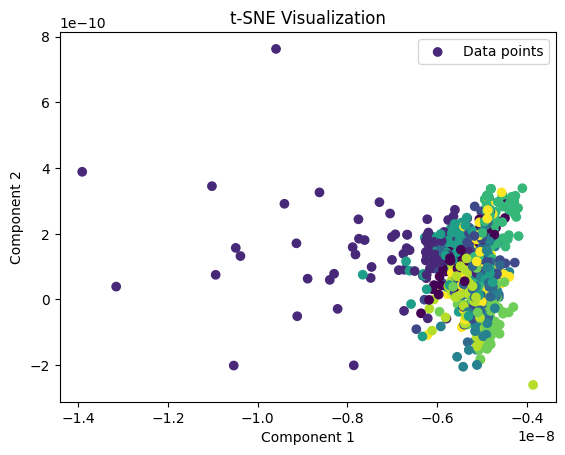

In [ ]:

tsne = TSNE(n_components=2, perplexity=X_train.shape[0]-1)

# Apply t-SNE to reduce dimensionality
X_embedded = tsne.fit_transform(X_train)

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)


# Plot the embedded data (adjust labels for your data)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train_le,label='Data points')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Visualization')
plt.legend()
plt.show()

In [ ]:
plt.savefig( '/content/drive/MyDrive/CS529/tsne.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [ ]:
# Save the plot
plt.savefig('tsne_plot.png',dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>